In [5]:
from random import random

import numpy as np
import pandas as pd
import pickle
import umap.umap_ as umap
import hdbscan
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from hdbscan.flat import HDBSCAN_flat
from config import OUTPUT_WITH_EMBEDDING_PICKLE_PATH, WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, DISTIL_ROBERTA_EMBEDDING_COLUMN, MPNET_EMBEDDING_COLUMN, LEGAL_BERT_EMBEDDING_COLUMN
from data_preperation import _leave_only_main_risks
from matplotlib import pyplot as plt

In [2]:
with open(OUTPUT_WITH_EMBEDDING_PICKLE_PATH, "rb") as f:
    df = pickle.load(f)
df = df[
    [WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, DISTIL_ROBERTA_EMBEDDING_COLUMN, LEGAL_BERT_EMBEDDING_COLUMN,
     MPNET_EMBEDDING_COLUMN]]

df.shape, Counter(df[RISK_1_COLUMN]).most_common()
# relevant_df = _leave_only_main_risks(relevant_columns_df) # todo: try different
# relevant_df.shape, relevant_columns_df.shape

((6734, 5),
 [('dp&p uninformed consent', 1264),
  ('onesided terms', 1172),
  ('collection of personal data', 526),
  ('other limitation of liability', 477),
  ('third party data transfers', 457),
  ('limited readability', 417),
  ('limitation of liability', 259),
  ('unfair terms', 239),
  ('storage and retention of personal data', 207),
  ('user content ownership', 187),
  ('data security', 176),
  ('uninformed consent', 159),
  ('tracking user information', 143),
  ('no refunds', 143),
  ('restricting user legal action - general', 141),
  ('dispute resolution clause', 125),
  ('limiting class action', 102),
  ('burdens associated with using the app - general', 57),
  ('international data transfers', 57),
  ('financial risks - general', 52),
  ('legally non compliant', 49),
  ('privacy risks', 46),
  ('processing user information', 44),
  ('eliminating or limiting access to purchased app assets or coins', 38),
  ('in app payments', 33),
  ('advertisements and spam', 32),
  ('severab

Find K means best number of clusters


100%|██████████| 19/19 [00:31<00:00,  1.64s/it]


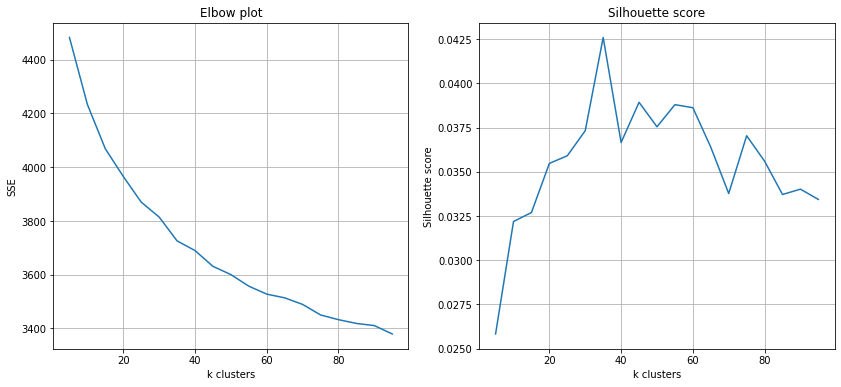

In [7]:
from evaluation_utils import plot_kmeans_inertia_and_silhouette


print("Find K means best number of clusters")
plot_kmeans_inertia_and_silhouette(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), range(5, 100, 5))

In [23]:
from evaluation_utils import random_search, generate_clusters, score_clusters, bayesian_search


space = {
    "min_cluster_size": range(2, 30),
    "min_samples": range(2, 30)
}

random_search(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), space, num_evals=100).head(20)

,run_id,min_cluster_size,min_samples,label_count,cost
83,83,4,2,3,0.038759
51,51,4,3,3,0.146867
8,8,3,3,3,0.146867
19,19,10,3,5,0.436887
16,16,8,4,5,0.448322
88,88,9,4,5,0.448322
89,89,10,4,3,0.450995
4,4,10,5,3,0.476240
5,5,5,6,5,0.507277
9,9,9,8,3,0.667360


In [29]:
clusters_default = generate_clusters(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]),
                                     umap_n_neighbors = 15,
                                     umap_n_components = 5,
                                     hdbscan_min_cluster_size = 10,
                                     random_state=42)

labels_def, cost_def, silhouette = score_clusters(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), clusters_default)
print(labels_def, cost_def, silhouette)



84 0.3543213543213543 -0.018963698


In [32]:
%%time

space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use = random_search(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), space, 100)
random_use.head(25)


100%|██████████| 100/100 [15:45<00:00,  9.46s/it]

CPU times: user 25min 22s, sys: 7min 32s, total: 32min 54s
Wall time: 15min 45s


,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost,silhouette
44,44,15,3,2,695,0.268637,-0.069465
6,6,13,5,2,716,0.302346,-0.064092
2,2,14,4,2,725,0.286011,-0.062933
86,86,12,5,2,685,0.281111,-0.060676
46,46,13,3,3,392,0.320166,-0.060114
53,53,13,3,3,392,0.320166,-0.060114
55,55,13,6,2,631,0.267746,-0.057897
20,20,15,6,3,341,0.350906,-0.057016
16,16,15,6,3,341,0.350906,-0.057016
80,80,14,3,3,380,0.313038,-0.056781


In [34]:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,30)),
    "n_components": hp.choice('n_components', range(3,100)),
    "min_cluster_size": hp.choice('min_cluster_size', range(5,50)),
    "random_state": 42
}

label_lower = 20
label_upper = 60
max_evals = 100

best_params_roberta, best_clusters_roberta, trials_roberta = bayesian_search(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]),
                                                                 space=hspace,
                                                                 label_lower=label_lower,
                                                                 label_upper=label_upper,
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [42:03<00:00, 25.24s/trial, best loss: 0.11969111969111969]
best:
{'min_cluster_size': 23, 'n_components': 70, 'n_neighbors': 6, 'random_state': 42}
label count: 25


In [35]:
trials_roberta.best_trial

{'state': 2,
 'tid': 88,
 'spec': None,
 'result': {'loss': 0.11969111969111969,
  'label_count': 25,
  'silhouette': 0.02050325,
  'status': 'ok'},
 'misc': {'tid': 88,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [88],
   'n_components': [88],
   'n_neighbors': [88]},
  'vals': {'min_cluster_size': [18],
   'n_components': [67],
   'n_neighbors': [3]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 6, 19, 17, 16, 22, 232000),
 'refresh_time': datetime.datetime(2022, 6, 19, 17, 16, 45, 524000)}

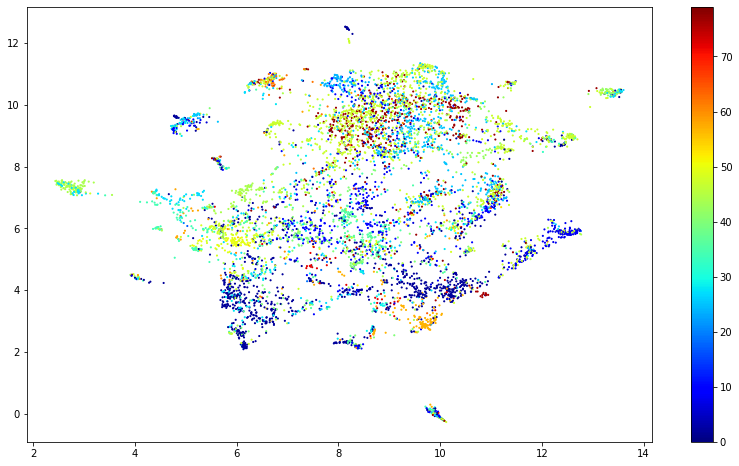

{0: 'dispute resolution clause - choice of venue creates an unfair advantage for app', 1: 'no refunds / financial risks - user liablity for hacked purchases', 2: 'onesided terms', 3: 'collection of personal information / tracking - cookies (third parties) / third party data transfers', 4: 'misundersood text', 5: 'data security - insufficient security measures', 6: 'privacy risks', 7: 'functionality', 8: 'storage and retention of personal data', 9: 'third party is traresfers / lack of transparency', 10: 'other limitation of liability', 11: 'international data transfer / uninformed consent - lack of transparency', 12: 'no refunds / no refunds even when app is faulty', 13: 'financial risks - eliminating or limiting access to purchased app assets or coins / limitation of liability / financial risks/cyber risks - user liablity for hacked actions', 14: 'collection of personal information', 15: 'tracking - cookies (third parties) / collection of personal data - exessive data collection / lack

In [81]:
from evaluation_utils import plot_gt_clusters, plot_clusters, combine_results, summarize_results


true_labels_with_description = list(df[RISK_1_COLUMN])
numerical_values_to_description = dict(enumerate(set(true_labels_with_description)))
description_to_numerical_values = {value: key for key, value in numerical_values_to_description.items()}
true_labels = [description_to_numerical_values[label_with_description] for label_with_description in true_labels_with_description]
plot_gt_clusters(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), true_labels, n_neighbors=15, min_dist=0.1)
print(numerical_values_to_description)

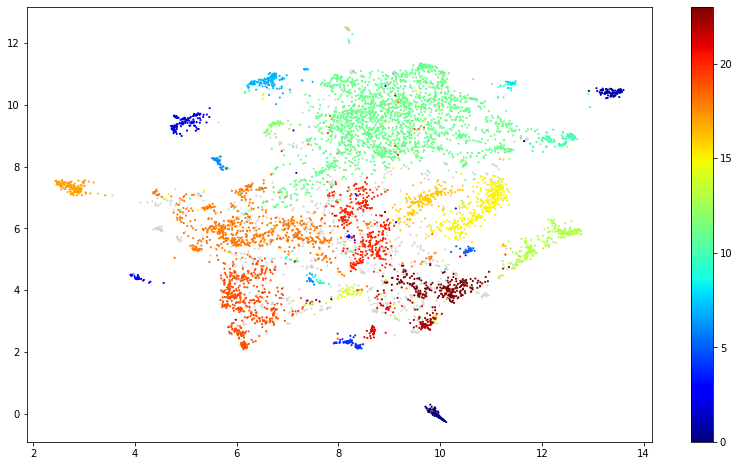

In [40]:
plot_clusters(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), best_clusters_roberta)

In [75]:
best_params_mpnet, best_clusters_mpnet, trials_mpnet = bayesian_search(list(df[MPNET_EMBEDDING_COLUMN]),
                                                                 space=hspace,
                                                                 label_lower=label_lower,
                                                                 label_upper=label_upper,
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [46:11<00:00, 27.72s/trial, best loss: 0.15]            
best:
{'min_cluster_size': 44, 'n_components': 70, 'n_neighbors': 22, 'random_state': 42}
label count: 5


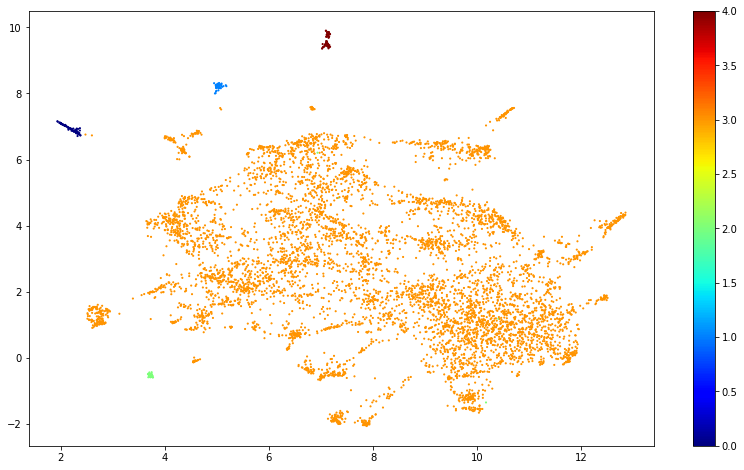

In [76]:
plot_clusters(list(df[MPNET_EMBEDDING_COLUMN]), best_clusters_mpnet)

In [77]:
best_params_legalbert, best_clusters_legalbert, trials_legalbert = bayesian_search(list(df[LEGAL_BERT_EMBEDDING_COLUMN]),
                                                                 space=hspace,
                                                                 label_lower=label_lower,
                                                                 label_upper=label_upper,
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [46:20<00:00, 27.81s/trial, best loss: 0.15]             
best:
{'min_cluster_size': 11, 'n_components': 41, 'n_neighbors': 18, 'random_state': 42}
label count: 2


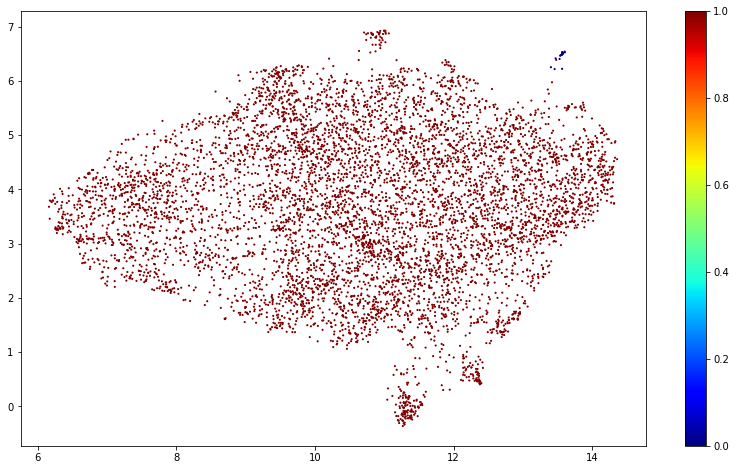

In [78]:
plot_clusters(list(df[LEGAL_BERT_EMBEDDING_COLUMN]), best_clusters_legalbert)

In [79]:
cluster_dict = {'label_roberta': best_clusters_roberta,
                'label_mpnet': best_clusters_mpnet,
                'label_legalbert': best_clusters_legalbert}

results_df = combine_results(df, cluster_dict)

results_df.head()

,why.not.ethical_clean,Risk 1,distilroberta_embedding,legalbert_embedding,mpnet_embedding,label_roberta,label_mpnet,label_legalbert
0,Its not exclusive to the person.,misundersood text,"[0.023553925, -0.01444637, 0.038104367, 0.0156...","[0.21741277, 0.013519102, -0.13954324, -0.1099...","[-0.016725117, 0.020999162, -0.016915562, -0.0...",18,3,1
1,The app cannot make the account owner liable f...,user content ownership,"[-0.0024117546, 0.009002485, 0.0194119, 0.0204...","[0.09979717, 0.16846906, 0.012315234, -0.02042...","[0.04070058, 0.034632064, -0.016977403, -0.002...",15,3,1
2,Being responsible for anything that happens in...,third party data transfer,"[0.020788975, 0.033457782, 0.013431481, 0.0325...","[-0.037051763, -0.058047704, -0.15357569, 0.07...","[0.018806899, 0.07402641, 0.025492294, -0.0142...",18,3,1
3,It's not so much unethical as it is vague.,third party data transfer,"[-0.018282065, -0.0018792199, 0.026722789, -0....","[-0.13648166, -0.14226694, 0.0681288, 0.174162...","[0.030179065, 0.107125275, 0.0035621584, 0.032...",11,3,1
4,The last portion about the terminating of the ...,limitation of liability - app will not become ...,"[0.011897946, 0.03957614, -0.0091056395, 0.004...","[-0.038581748, 0.03626928, 0.11415291, 0.11283...","[0.015553814, 0.089474596, 0.013865434, -0.023...",-1,3,1


In [70]:
import collections
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")



def get_group(df, category_col, category):
    """
    Returns documents of a single category

    Arguments:
        df: pandas dataframe of documents
        category_col: str, column name corresponding to categories or clusters
        category: int, cluster number to return
    Returns:
        single_category: pandas dataframe with documents from a single category
    """

    single_category = df[df[category_col]==category].reset_index(drop=True)

    return single_category


def most_common(lst, n_words):
    """
    Get most common words in a list of words

    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return

    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter=collections.Counter(lst)
    return counter.most_common(n_words)


def extract_labels(category_docs, print_word_counts=False):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, ojects, and nouns

    Argument:
        category_docs: list of documents, all from the same category or
                       clustering
        print_word_counts: bool, True will print word counts of each type in this category

    Returns:
        label: str, group label derived from concatentating most common
               verb, object, and two most common nouns

    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []

    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to
    # running lists for whole cluster
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())

                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())

                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())

                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())

    # for printing out for inspection purposes
    if print_word_counts:
        for word_lst in [verbs, dobjs, nouns, adjs]:
            counter=collections.Counter(word_lst)
            print(counter)

    # take most common words of each form
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]

    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]

    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]

    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]

    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]

    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)

    if '' in label_words:
        label_words.remove('')

    label = '_'.join(label_words)

    return label



def get_top_category(df_label, df_summary):
    """
    Returns a dataframe comparing a single model's results to ground truth
    label to evalute cluster compositions and derived label relative to labels
    and counts of most commmon ground truth category

    Arguments:
        df_label: pandas dataframe, each row as a document with extracted and ground truth labels
                  (result of `combine_ground_truth` function)
        df_summary: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
                    (result from `apply_and_summarize_labels` function)

    Returns:
        df_result: pandas dataframe with each row containing information on
                   each cluster identified by this model, including count,
                   extracted label, most represented ground truth label name,
                   count and percentage of that group
    """
    df_label_ground = (df_label.groupby('label')
                      .agg(top_ground_category=('category', lambda x:x.value_counts().index[0]),
                           top_cat_count = ('category', lambda x:x.value_counts()[0]))
                      .reset_index())

    df_result = pd.merge(df_summary, df_label_ground, on='label', how='left')
    df_result['perc_top_cat'] = df_result.apply(lambda x: int(round(100*x['top_cat_count']/x['count'])), axis=1)

    return df_result

def combine_ground_truth(df_clusters, df_ground, key):
    """
    Combines dataframes of documents with extracted and ground truth labels

    Arguments:
        df_clusters: pandas dataframe, each row as a document with corresponding extracted label
        df_ground: pandas dataframe, each row as a document with corresponding ground truth label
        key: str, key to merge tables on

    Returns:
        df_combined: pandas dataframe, each row as a document with extracted and ground truth labels
    """
    df_combined = pd.merge(df_clusters, df_ground, on=key, how = 'left')
    return df_combined



def get_top_category(df_label, df_summary):
    """
    Returns a dataframe comparing a single model's results to ground truth
    label to evalute cluster compositions and derived label relative to labels
    and counts of most commmon ground truth category

    Arguments:
        df_label: pandas dataframe, each row as a document with extracted and ground truth labels
                  (result of `combine_ground_truth` function)
        df_summary: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
                    (result from `apply_and_summarize_labels` function)

    Returns:
        df_result: pandas dataframe with each row containing information on
                   each cluster identified by this model, including count,
                   extracted label, most represented ground truth label name,
                   count and percentage of that group
    """
    df_label_ground = (df_label.groupby('label')
                      .agg(top_ground_category=(RISK_1_COLUMN, lambda x:x.value_counts().index[0]),
                           top_cat_count = (RISK_1_COLUMN, lambda x:x.value_counts()[0]))
                      .reset_index())

    df_result = pd.merge(df_summary, df_label_ground, on='label', how='left')
    df_result['perc_top_cat'] = df_result.apply(lambda x: int(round(100*x['top_cat_count']/x['count'])), axis=1)

    return df_result



def apply_and_summarize_labels(df, category_col):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """

    numerical_labels = df[category_col].unique()

    # create dictionary of the numerical category to the generated label
    label_dict = {}
    for label in numerical_labels:
        current_category = list(get_group(df, category_col, label)[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN])
        label_dict[label] = extract_labels(current_category)

    # create summary dataframe of numerical labels and counts
    summary_df = (df.groupby(category_col)[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN].count()
                    .reset_index()
                    .rename(columns={WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN:'count'})
                    .sort_values('count', ascending=False))

    # apply generated labels
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis = 1)

    return summary_df

In [46]:
results_df.head()

,why.not.ethical_clean,Risk 1,distilroberta_embedding,legalbert_embedding,mpnet_embedding,label_roberta
0,Its not exclusive to the person.,misundersood text,"[0.023553925, -0.01444637, 0.038104367, 0.0156...","[0.21741277, 0.013519102, -0.13954324, -0.1099...","[-0.016725117, 0.020999162, -0.016915562, -0.0...",18
1,The app cannot make the account owner liable f...,user content ownership,"[-0.0024117546, 0.009002485, 0.0194119, 0.0204...","[0.09979717, 0.16846906, 0.012315234, -0.02042...","[0.04070058, 0.034632064, -0.016977403, -0.002...",15
2,Being responsible for anything that happens in...,third party data transfer,"[0.020788975, 0.033457782, 0.013431481, 0.0325...","[-0.037051763, -0.058047704, -0.15357569, 0.07...","[0.018806899, 0.07402641, 0.025492294, -0.0142...",18
3,It's not so much unethical as it is vague.,third party data transfer,"[-0.018282065, -0.0018792199, 0.026722789, -0....","[-0.13648166, -0.14226694, 0.0681288, 0.174162...","[0.030179065, 0.107125275, 0.0035621584, 0.032...",11
4,The last portion about the terminating of the ...,limitation of liability - app will not become ...,"[0.011897946, 0.03957614, -0.0091056395, 0.004...","[-0.038581748, 0.03626928, 0.11415291, 0.11283...","[0.015553814, 0.089474596, 0.013865434, -0.023...",-1


In [58]:
example_category = list(get_group(results_df, 'label_roberta', 18)[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN])
extract_labels(example_category, True)

Counter({'think': 18, 'waive': 18, 'says': 12, 'saying': 11, 'allowed': 10, 'unethical': 7, 'giving': 7, 'taking': 6, 'understand': 6, 'held': 5, 'requires': 5, 'state': 5, 'need': 5, 'believe': 5, 'stating': 5, 'removes': 5, 'waived': 5, 'states': 5, 'limits': 4, 'needs': 4, 'reserve': 4, 'governed': 4, 'stated': 4, 'feel': 4, 'allow': 4, 'written': 4, 'gives': 3, 'makes': 3, 'disregards': 3, 'allows': 3, 'accept': 3, 'mean': 3, 'feels': 3, 'entitled': 3, 'asks': 3, 'hold': 3, 'like': 3, 'want': 3, 'means': 3, 'apply': 3, 'making': 3, 'waiving': 3, 'deemed': 2, 'depends': 2, 'having': 2, 'taken': 2, 'provide': 2, 'force': 2, 'attempts': 2, 's': 2, 'assumes': 2, 'sounds': 2, 'violates': 2, 'accepting': 2, 'revoke': 2, 'explain': 2, 'given': 2, 'agree': 2, 'outlined': 2, 'implies': 2, 'retain': 2, 'asking': 2, 'forces': 2, 'restricting': 2, 'vary': 2, 'expected': 2, 'mention': 2, 'tells': 2, 'specified': 2, 'said': 2, 'rights': 2, 'prevents': 2, 'requiring': 2, 'takes': 2, 'appears': 2,

'think_right_user_company'

In [57]:
results_df.head()

,why.not.ethical_clean,Risk 1,distilroberta_embedding,legalbert_embedding,mpnet_embedding,label_roberta
0,Its not exclusive to the person.,misundersood text,"[0.023553925, -0.01444637, 0.038104367, 0.0156...","[0.21741277, 0.013519102, -0.13954324, -0.1099...","[-0.016725117, 0.020999162, -0.016915562, -0.0...",18
1,The app cannot make the account owner liable f...,user content ownership,"[-0.0024117546, 0.009002485, 0.0194119, 0.0204...","[0.09979717, 0.16846906, 0.012315234, -0.02042...","[0.04070058, 0.034632064, -0.016977403, -0.002...",15
2,Being responsible for anything that happens in...,third party data transfer,"[0.020788975, 0.033457782, 0.013431481, 0.0325...","[-0.037051763, -0.058047704, -0.15357569, 0.07...","[0.018806899, 0.07402641, 0.025492294, -0.0142...",18
3,It's not so much unethical as it is vague.,third party data transfer,"[-0.018282065, -0.0018792199, 0.026722789, -0....","[-0.13648166, -0.14226694, 0.0681288, 0.174162...","[0.030179065, 0.107125275, 0.0035621584, 0.032...",11
4,The last portion about the terminating of the ...,limitation of liability - app will not become ...,"[0.011897946, 0.03957614, -0.0091056395, 0.004...","[-0.038581748, 0.03626928, 0.11415291, 0.11283...","[0.015553814, 0.089474596, 0.013865434, -0.023...",-1


In [60]:
cluster_summary = apply_and_summarize_labels(results_df, 'label_roberta')
cluster_summary.head(20)

,label_roberta,count,label
12,11,2088,think_datum_user
0,-1,806,think_right_user_company
19,18,699,think_right_user_company
20,19,512,notified_term_user_change
16,15,368,think_datum_app_user
21,20,343,think_content_game_user
24,23,254,notified_account_user
14,13,250,delete_datum_time
17,16,172,need_information_game_player
18,17,141,need_english_language_translation


In [63]:
labeled_clusters = pd.merge(results_df, cluster_summary[['label_roberta', 'label']], on='label_roberta', how = 'left')
labeled_clusters[[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, "label", "label_roberta"]].sample(20)

,why.not.ethical_clean,Risk 1,label,label_roberta
2711,Even if consent is withdrawn still processing ...,dp&p uninformed consent,use_consent_datum,12
2579,This app is providing a service to its users a...,limitation of liability,think_datum_app_user,15
611,it says it doesnt offer 100% protection of per...,data security,think_datum_user,11
1377,This paragraph is unethical because the timefr...,collection of personal data,think_datum_user,11
3134,Your data such as user name and password could...,third party data transfers,think_datum_user,11
550,It is unnecessary to note that this will resul...,unfair terms,need_information_game_player,16
4584,Plarium is requiring you to waive any liabilit...,other limitation of liability,think_datum_app_user,15
4763,Minors between 13 and 16 should not be allowed...,uninformed consent,block_information_age_child,2
2999,I do not see a need to use GPS location. It is...,tracking user information,think_datum_user,11
88,the fact that the privacy policy does not appl...,third party data transfers,think_datum_user,11


In [64]:
Counter(labeled_clusters["label_roberta"]).most_common()

[(11, 2088),
 (-1, 806),
 (18, 699),
 (19, 512),
 (15, 368),
 (20, 343),
 (23, 254),
 (13, 250),
 (16, 172),
 (17, 141),
 (7, 137),
 (2, 134),
 (10, 125),
 (1, 95),
 (0, 95),
 (22, 85),
 (4, 68),
 (6, 63),
 (12, 56),
 (3, 51),
 (21, 44),
 (14, 43),
 (5, 41),
 (8, 40),
 (9, 24)]

In [68]:
labeled_clusters[labeled_clusters['label_roberta']==1].drop(columns=[MPNET_EMBEDDING_COLUMN, LEGAL_BERT_EMBEDDING_COLUMN, DISTIL_ROBERTA_EMBEDDING_COLUMN]).sample(10)

,why.not.ethical_clean,Risk 1,label_roberta,label
433,It is unethical to disable features of the pro...,uninformed consent,1,use_cookie_user
5637,You cannot use it properly without cookies,unfair terms,1,use_cookie_user
4419,There is no option available if you do not wis...,dp&p uninformed consent,1,use_cookie_user
856,Cookies take your data and use it for monetary...,onesided terms,1,use_cookie_user
4772,Lack of specificity on Privacy and Cookie poli...,uninformed consent,1,use_cookie_user
5501,users should be allowed to use the service whi...,unfair terms,1,use_cookie_user
4709,I believe it is unethical to use cookies for a...,tracking user information,1,use_cookie_user
2010,Limited service available because we declined ...,dp&p uninformed consent,1,use_cookie_user
5201,blocking/deleting cookies means you can't use ...,unfair terms,1,use_cookie_user
3983,It does not specify what other purposes it has...,dp&p uninformed consent,1,use_cookie_user


In [71]:
get_top_category(labeled_clusters, cluster_summary)

,label_roberta,count,label,top_ground_category,top_cat_count,perc_top_cat
0,11,2088,think_datum_user,dp&p uninformed consent,732,35
1,-1,806,think_right_user_company,onesided terms,283,35
2,18,699,think_right_user_company,onesided terms,283,40
3,19,512,notified_term_user_change,onesided terms,338,66
4,15,368,think_datum_app_user,dp&p uninformed consent,68,18
5,20,343,think_content_game_user,user content ownership,84,24
6,23,254,notified_account_user,onesided terms,207,81
7,13,250,delete_datum_time,storage and retention of personal data,144,58
8,16,172,need_information_game_player,collection of personal data,52,30
9,17,141,need_english_language_translation,limited readability,117,83


In [80]:
model_dict = {'roberta': ['label_roberta', best_params_roberta, trials_roberta],
              'mpnet': ['label_mpnet', best_params_mpnet, trials_mpnet],
              'legalbert': ['label_legalbert', best_params_legalbert, trials_legalbert]
               }

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
0,roberta,0.131,0.275,0.119691,25,6,70,23,42
1,mpnet,-0.000,0.013,0.150000,5,22,70,44,42
2,legalbert,0.000,0.001,0.150000,2,18,41,11,42
